In [10]:
import os
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
tf.random.set_seed(1337)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2

TOKENIZER_MAX_WORDS = 10000

data = pd.concat([chunk for chunk in tqdm(pd.read_csv("./clean_dataset.csv", chunksize=1000), desc="loading dataset")])

train_data, test_data = train_test_split(data, test_size=TEST_SPLIT, random_state=1337, stratify=data["label"])


print("--------------------------------------------")
print("--------------------------------------------")
label_counts = train_data["label"].value_counts()
print(label_counts)
count_0 = label_counts[0]
count_1 = label_counts[1]
print(f"Number of 0 labels: {count_0}")
print(f"Number of 1 labels: {count_1}")
print("--------------------------------------------")
test_label_counts = test_data["label"].value_counts()
print(test_label_counts)
test_count_0 = test_label_counts[0]
test_count_1 = test_label_counts[1]
print(f"Number of test 0 labels: {test_count_0}")
print(f"Number of test 1 labels: {test_count_1}")
print("--------------------------------------------")
print("--------------------------------------------")


print(f"train data shape: {train_data.shape}")
print(f"test data shape:  {test_data.shape}")

print(f"tokenizing the test dataset")
tokenizer = Tokenizer(num_words=TOKENIZER_MAX_WORDS)
tokenizer.fit_on_texts(train_data["text"])

loaded_models = tf.keras.models.load_model("INSERT MODEL PATH")

X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["text"]), maxlen=500) # TODO: CHANGE 500 TO REFLECT THE MODEL PARAMS
Y_test = test_data["label"]

y_pred_model = loaded_models.predict(X_test).argmax(axis=-1)

loading dataset: 50it [00:00, 119.87it/s]


--------------------------------------------
--------------------------------------------
label
1    20000
0    20000
Name: count, dtype: int64
Number of 0 labels: 20000
Number of 1 labels: 20000
--------------------------------------------
label
1    5000
0    5000
Name: count, dtype: int64
Number of test 0 labels: 5000
Number of test 1 labels: 5000
--------------------------------------------
--------------------------------------------
train data shape: (40000, 2)
test data shape:  (10000, 2)
tokenizing the test dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step


y_pred_classes
[0 0 0 ... 0 0 0]


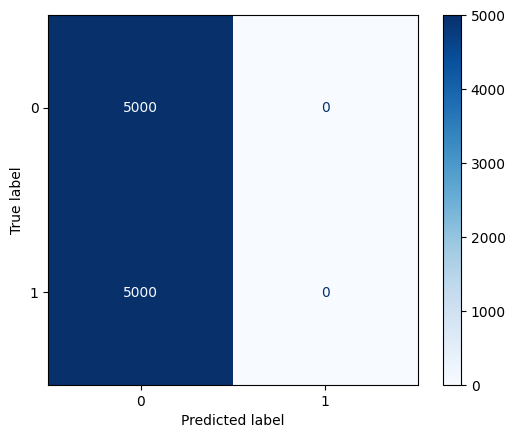

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
print(f"y_pred_classes\n{y_pred_model}")

conf_matrix = confusion_matrix(test_data["label"], y_pred_model)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["text"]), maxlen=500) # TODO: CHANGE 500 TO REFLECT THE MODEL PARAMS
y_pred_model = loaded_models.predict(X_test).argmax(axis=-1)


metrics = loaded_models.evaluate(X_test, Y_test)
print(f"LSTM with hyperparameters")
print(f"metrics: {metrics}")

from sklearn.metrics import accuracy_score, recall_score, f1_score

y_pred = loaded_models.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(Y_test, y_pred_binary)
recall = recall_score(Y_test, y_pred_binary)
f1 = f1_score(Y_test, y_pred_binary)

with open("TMP_hyp_lstm.txt", "a") as file:
  file.write(f"LSTM with hyperparameters")
  file.write(f"accuracy:      {accuracy}")
  file.write(f"test recall:   {recall}\n")
  file.write(f"test f1:       {f1}\n\n")

313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8526 - loss: 0.4152
LSTM with hyperparameters
metrics: [0.41568177938461304, 0.855400025844574]
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step
